<h1 style="color:#daa03d; text-align:center;"> Modelling interspecific interactions

Interspecific interactions is a study of all interactions between species, its causes and consequences. Those interactions can be categorized into five groups:

- competition
- predation
- commensalism
- mutualism 
- parasitism

In our work we will consider differential models of predation and mutualism.

We will start with the Lotka-Volterra model, discuss its phase plot and solve an example using a numerical method. What follows is a modification of L-V model its phase plot and example solving.

Regarding mutualism we will consider two models: basic and with functional response. Except for the phase plot and an example numerical solution we will go through an analysis of each model.

To solve systems of differential equations we will be using the Runge-Kutta 4<sup>th</sup> order method for the reason being its accuracy &mdash; its truncation error is $O(h^4)$.

**Warning!**

Images of phase plots are generated using Makie and are imported into the notebook. Using Makie in Jupyter is **not** advised.

In [2]:
using Statistics
using Plots
using CSV
using DataFrames
# pgfplotsx() 

In [3]:
"""
    evaluate(array::Array{Function, 1}, X::Real, Y::Array{Real, 1})::Array{Real, 1}
Return an array with values of functions f(t, y₁, y₂) defined in array for given point X and values of y₁, y₂ defined in Y.
"""
function evaluate(array::Array{Function, 1}, X::Real, Y::Array{T, 1})::Array{T, 1} where T <: Real 
    return [i(X, Y[1], Y[2]) for i in array]
end


"""
    runge_kutta(F::Array{Function, 1}, x::Real, X::Real, Y::Array{T, 1}, h::Real=1e-3)::Array{T, 2} where T <: Real
Return an array with values of functions which are solutions to the system of differential equations defined by the array.
X and Y are initial conditions, x is the maximum point.
"""
function runge_kutta(F::Array{Function, 1}, x::Real, X::Real, Y::Array{T, 1}, h::Real=1e-3)::Array{T, 2} where T <: Real
    n = round(Int64, x / h)
    array = zeros((n, 2))
    for i in 1:n
        k₁ = evaluate(F, X, Y)
        k₂ = evaluate(F, X + 1/2 * h, Y .+ 1/2 * h * k₁)
        k₃ = evaluate(F, X + 1/2 * h, Y .+ 1/2 * h * k₂)
        k₄ = evaluate(F, X + h, Y .+ h * k₃)
        Y = @. Y + h / 6 * (k₁ + 2*k₂ + 2*k₃ + k₄)
        X += h
        array[i, :] = Y
    end
    return array
end

runge_kutta

In [4]:
# Forward Euler method
"""
   euler(F::Array{Function, 1}, x::Real, X:::Real, Y::Array{T, 1}, h::Real=1e-3)::Array{T, 2} where T <: Real
Docstring.
"""
function euler(F::Array{Function, 1}, x::Real, X::Real, Y::Array{T, 1}, h::Real=1e-3)::Array{T, 2} where T <: Real
    n = round(Int64, x / h)
    array = zeros((n, 2))
    for i in 1:n
        Y = Y .+ h * evaluate(F, X, Y)
        X += h
        array[i, :] = Y
    end
    return array
end        

euler

In [ ]:
# Please, do not run this cell in Jupyter.
using AbstractPlotting
using CairoMakie

"""
    phase_portrait(𝐹::Array{Function, 1}, P::Real, title::String, xlab::String, ylab::String)::Scene
Docstring
"""
function phase_portrait(𝐹::Array{Function, 1}, P::Real, title::String, xlab::String, ylab::String)::Scene
    f(x, y) = Point2f0(𝐹[1](0, x, y), 𝐹[2](0, x, y))
    xs = ys = LinRange(0, P, 3 * ceil(P))
    scene = streamplot(f, xs, ys, arrow_size=1.0, linewidth=1, colormap=:magma)
    axis = scene[Axis]
    axis.names.axisnames = (xlab, ylab)
    axis.names.title = title
    axis.names.font = ("Latin Modern Math", "Latin Modern Math")
    axis.ticks.font = ("Latin Modern Math", "Latin Modern Math")
    return scene
end;

# Predation

Predation is a relation between two species: prey and the predator. They regulate each other's populations. If the number of prey decreases as a result of intensive hunting, the number of predators will also decrease after some time due to lack of food. This in turn will allow a revival of the prey population. The result of these relationships are cyclical changes in the populations. Changes in the predator-prey system are negative feedback loops.

A good example is a fox-rabbit relation

## Lotka-Volterra

Around the year 1920 there were two mathematicians: Lotka and Volterra who independently proposed a differential model that described the dynamics of a predator-prey relation. This naive model is mostly discussed as an introduction to relation modelling and because of its historical significance.

This model generally shows the oscillatory tendency of this system, but has many limitations due to its assumptions [1]:

 1. the prey population will grow exponentially when the predator is absent; 
 2. the predator population will starve in the absence of the prey population (as opposed to switching to another type of prey);
 3. predators can consume infinite quantities of prey; 
 4. there is no environmental complexity (in other words, both populations are moving randomly through a homogeneous environment).
 
From that we can formulate the system of differential equations:
 
$$\begin{cases} N' = N\left(a - b P\right)\\ P' = P\left(c N - d\right)\end{cases}$$
 
where $a, b, c, d$ are positive constants and $N, P$ are respectively prey population and predator population.

The first equation describes the change in prey population:
- $a N$ (breeding);
- $- b N P$ (being eaten - more prey = more food for predator, more predator = more prey is eaten).

The second equation describes the change in predator population:
- $c P N$ (eating prey);
- $- d P$ (competition - more predator = less food for each one).

### Phase portrait

In [6]:
# system od ODEs
a = 1.0; b = 1.0; c = 1.0; d = 1.0
array = [(t, N, P) -> (N * (a - b * P)),
         (t, N, P) -> (P * (c * N - d))]

a = phase_portrait(array, 4, "LV phase portrait", "prey population", "predator population")
save("lv_phaseplot.png", a);

![LV phase portrait](lv_phaseplot.png)

What we can is that in this model the populations regulate each other and oscilate around a neutrally stable critical point at (1, 1).

### Example solving
We will solve an example of such system.

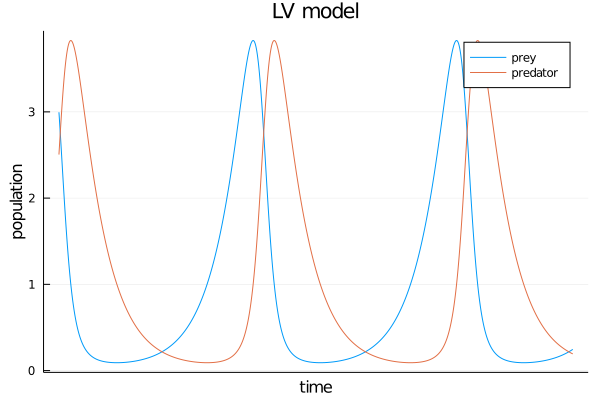

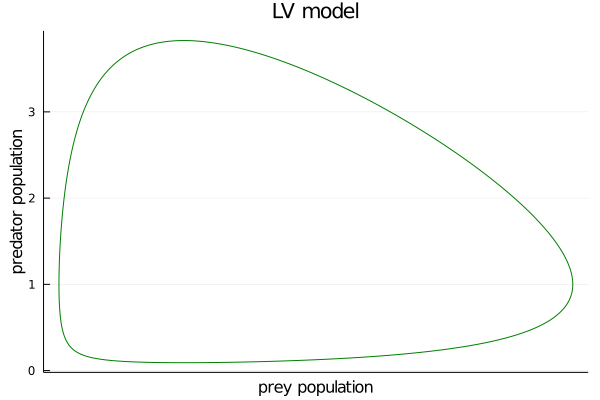

In [13]:
# system od ODEs
a = 1.0; b = 1.0; c = 1.0; d = 1.0
array = [(t, N, P) -> (N * (a - b * P)),
         (t, N, P) -> (P * (c * N - d))]

# illustrative initial values other than 0 (any 0 would simplify the model)
Y2 = [3.0, 2.5]

# solution
sol = runge_kutta(array, 20, 0, Y2)

# plotting
p = Plots.plot(sol[:, 1], label="prey", title="LV model",
    xlabel="time", ylabel="population", xticks=nothing)
p = Plots.plot!(sol[:, 2], label="predator")
display(p)

p = Plots.plot(sol[:, 1], sol[:, 2], label=nothing, title="LV model",
    xlabel="prey population", ylabel="predator population", color=:green, xticks=nothing)
display(p)

We can clearly see how predator and prey influence each other. Big prey population causes a huge growth in predator population and when that begins to happen the prey becomes smaller as it is eaten by the predator. What follows is a decrease in predator population due to lack of foodwhich causes the prey population to breed more freely and grow.

## Modified Lotka-Volterra [2]
We can think of the basic Lotka-Volterra relation as a simple case of given system:

$$\begin{cases} N' = F(N, P)\\ P' = G\left(N, P\right)\end{cases}$$

The change in prey population depends somehow on both prey and predator, the same applies to the change of predator population.

We will try to impove the model by working on F and G.

As for the prey in Lotka-Volterra $F\left(N, P\right) = a N - b N P$.

Since we expect prey to satisfy the logistic growth we will replace the first term with a logistic factor so in absence of predator the population doesn't explode to infinity.

The predator responds differently depending on the density of the prey, so intead of having a simple linear relation ($bN$ factor) we should consider a function $R$ that represents the reponse of predator to the density of prey.

$$ F(N, P) = N r_1\left(1 - \frac{N}{k}\right) - P \frac{A N}{N + B} $$

where $r_1$ is the growth rate of prey, $k$ is the enviromental capacity of prey.
Here we propose $R = \frac{A N}{N + B}$, where $A, B$ modify accesibility of prey to predator.

As for the predator in Lotka-Volterra $G\left(N, P\right) = - d P + c P N$.

Since the predator population is strictly connected and therefore restricted by prey population we can consider it following the logistic model.

$$ G(N, P) = P r_2\left(1 - \frac{P}{p N}\right) $$

where $r_2$ is the growth rate of predator, $p$ is the proportionality factor relating the maximum population of prey and predator.

All considered we end up with following system:

$$\begin{cases} N' = N r_1\left(1 - \frac{N}{k}\right) - P \frac{A N}{N + B}\\ P' = P r_2\left(1 - \frac{P}{p N}\right)\end{cases}$$

Note that we can try to improve the Lotka-Volterra model in many ways, taking into account different assumptions (the hardest one to overcome is the assumption of lack of external factors). We propose only one out of infinitely many solutions.

### Phase portrait

In [8]:
# system od ODEs
r_1 = 1.0; r_2 = 1.0
k = 1.0; p = 1.0
A = 1.0; B = 1.0
array = [(t, N, P) -> N * r_1 * (1 - N / k) - P * A * N / (N + B),
         (t, N, P) -> P * r_2 * (1 - P / (p * N))]

a = phase_portrait(array, 2, "MLV phase portrait", "prey population", "predator population")
save("mlv_phaseplot.png", a);

![MLV phase portrait](mlv_phaseplot.png)

We can see that in our improved model populations approach a stability point around (0.6, 0.6) (note that this depends mailny on $k$ and $p$ which describe populations capacities). We have to remember that we assumed this system is isolated. In such a case we should expect the populations to stabilize at a point where the system is in equilibrium.

The main reason for the difference between this model and basic Lotka-Volterra is the logistic factor - both populations tend to stabilize.

### Example solving
We will solve two examples of such system.

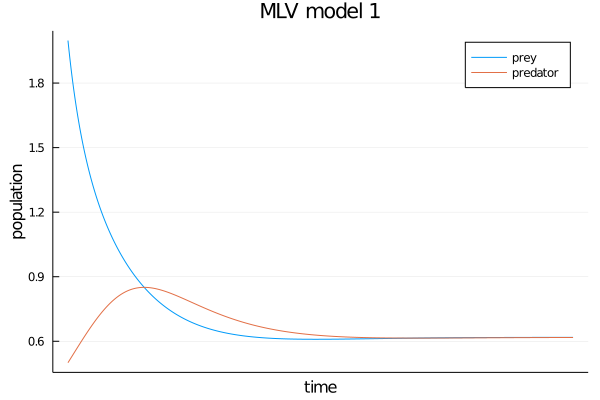

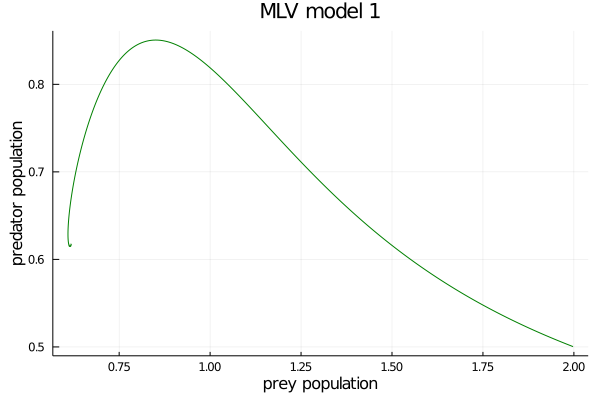

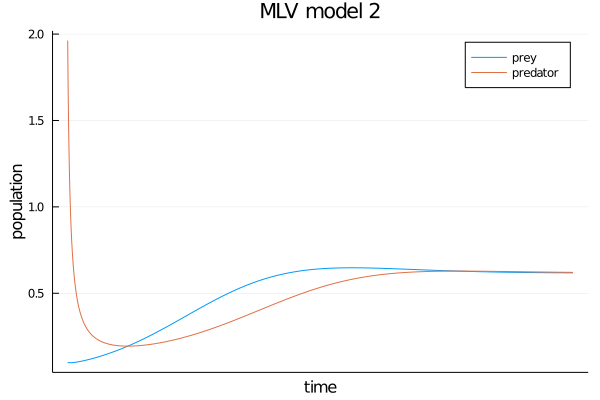

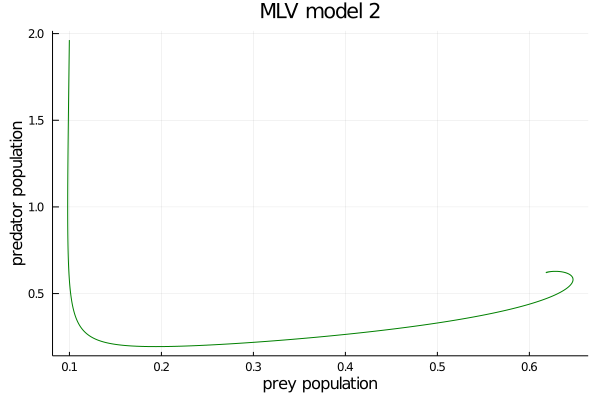

In [16]:
# system od ODEs (the same for both examples)
r_1 = 1.0; r_2 = 1.0
k = 1.0; p = 1.0
A = 1.0; B = 1.0
array = [(t, N, P) -> N * r_1 * (1 - N / k) - P * A * N / (N + B),
         (t, N, P) -> P * r_2 * (1 - P / (p * N))]

# illustrative initial values other than 0 (any 0 would simplify the model)
Y1 = [2.0, 0.5]
Y2 = [0.1, 2.0]

# solution
sol1 = runge_kutta(array, 10, 0, Y1)
sol2 = runge_kutta(array, 10, 0, Y2)

# plotting
p = Plots.plot(sol1[:, 1], label="prey", title="MLV model 1",
    xlabel="time", ylabel="population", xticks=nothing)
p = Plots.plot!(sol1[:, 2], label="predator")
display(p)

p = Plots.plot(sol1[:, 1], sol1[:, 2], label=nothing, title="MLV model 1",
    xlabel="prey population", ylabel="predator population", color=:green)
display(p)

p = Plots.plot(sol2[:, 1], label="prey", title="MLV model 2",
    xlabel="time", ylabel="population", xticks=nothing)
p = Plots.plot!(sol2[:, 2], label="predator")
display(p)

p = Plots.plot(sol2[:, 1], sol2[:, 2], label=nothing, title="MLV model 2",
    xlabel="prey population", ylabel="predator population", color=:green)
display(p)

What was expected happened. In both situations the populations eventually stabilized at around $(0.6, 0.6)$.

In the first example where the prey population was big at the start it started stabilizing (because of the logistic factor) but due to its size predator quickly started growing and lowered the prey population much below its goal. Because of that we had a lot of predator and a small number or prey. Soon the predator started dying and prey was let to breed and both of them stabilized.

In the second example the predator population was huge at the start. Because of lack of food it starte plummeting, this let the prey to breed and stabilize. The prey population growth let predator thrive and eventually both populations stabilized.

## Evaluation and analysis

For comparison we will plot real world population of Canadian lynx and Snowshoe hare. This data is frequently used as a representation of predator-prey model (mailny Lotka-Volterra), it comes from records of the numbers of pelts brought into the Hudson Bay Company. We will then conclude some characterisctics of two models discussed above.

For readability purposes the trajectory is considered for limited dataset.

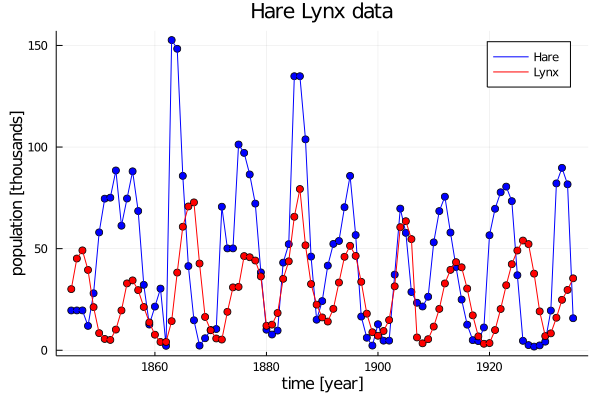

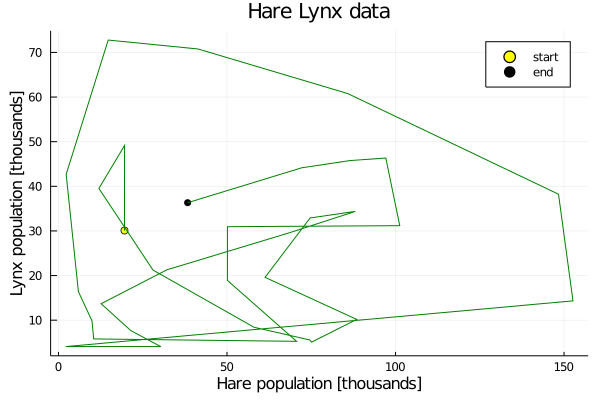

In [17]:
# loading the data
data = CSV.File("hare_lynx_data.csv") |> DataFrame;
year = data[:Year]
hare = data[:Hare]
lynx = data[:Lynx]

# plotting
p = Plots.scatter(year, hare, label=nothing, title="Hare Lynx data",
    xlabel="time [year]", ylabel="population [thousands]", color=:blue)
p = Plots.plot!(year, hare, label="Hare", color=:blue)

p = Plots.scatter!(year, lynx, label=nothing, color=:red)
p = Plots.plot!(year, lynx, label="Lynx", color=:red)
display(p)

# smaller dataset for readability
hare = hare[1:35]
lynx = lynx[1:35]

p = Plots.scatter([hare[1]], [lynx[1]], label="start", title="Hare Lynx data",
    xlabel="Hare population [thousands]", ylabel="Lynx population [thousands]", color=:yellow)
p = Plots.scatter!([hare[end]], [lynx[end]], label="end", title="Hare Lynx data", color=:black)
p = Plots.plot!(hare, lynx, label=nothing, color="green")

display(p)

We can clearly see that both models are far from accurate, but they give us some intuition about what is happening between two species that are in this relation.

The simple L-V predicts the oscilation characteristic of this data.

Here the modified model is unfortunately not really realistic, it does not predict the behaviour of this system. Probably in a more isolated model we could see the stabilizing tendency. However maybe if the data was collected until this day we could see the expected behaviour.

# Mutualism

Mutualism is the relationship between organisms belonging to two species that brings benefits to both sides. There are obligatory mutualism (symbiosis) and facultative mutalism (p
- bees and flowers (bees help to pollinate flowers);
- cape buffalos and red-billed oxpecker (the birds clean the skin of a buffalo from any parasites at the same time gathering food and fur for building nests);
- Suillus luteus and Pinus sylvestris (in this instance the mushroom can only grow near the pine).

## Basic models

We can derive a very naive system easily from standard Lotka-Volterra system:
<!-- A very naive approach would be a system like this one: -->

 $$ \begin{cases} y_1^{'} = \alpha_1 y_1 + \beta_1 y_1 y_2 \\ y_{2}^{'} = \alpha_2 y_2 + \beta_2 y_1 y_2\end{cases}$$
 
where constants $\alpha_1$, $\alpha_2$, $\beta_1$, $\beta_2$ are all positive. We can immediately see that this model is completely unreallistic since both species would grow infinitely. This is illustrated in a direction field below:

In [11]:
# Please, do not run this cell in Jupyter
α₁ = 1; β₁ = 1; α₂ = 1; β₂ = 1;
arr = [(t, y₁, y₂) -> y₁*(α₁ + β₁*y₂),
       (t, y₁, y₂) -> y₂*(α₂ + β₂*y₁)]

a = phase_portrait(arr, 4, "Naive mutualism", "population 1", "population 2")
save("mlv_phaseplot.png", a);

<img src="mut_naive.png" width="700" height="450">

It seems reasonable to add an environmental capacity $K$ to bound the unlimited growth, and thus we will obtain a system:

$$
\begin{cases} 
y_{1}^{'} = r_1y_1\left(1 - \frac{y_1}{K_1} + b_{12}\frac{y_2}{K_1}\right) \\ 
y_2^{'} = r_2y_2\left(1 - \frac{y_2}{K_2}+b_{21}\frac{y_1}{K_2}\right)
\end{cases},
$$

where constants $r_1$, $r_2$, $K_1$, $K_2$, $b_{12}$, $b_{21}$ are all positive and:
 - $r_1$, $r_2$ denote the intrinsic growth rate of $y_1$, $y_2$ respectively,
 - $K_1$, $K_2$ are environemental capacities for $y_1$, $y_2$ respectively,
 - $b_{12}$, $b_{21}$ measure the mutualistic effect of $y_1$ on $y_2$, $y_2$ on $y_1$ respectively.

We would like to find the critical points of this system. In order make this process easier, we use following substitutions(proposed by Murray[2]):

$$ u_1 = \frac{y_1}{K_1},\quad u_2 = \frac{y_2}{K_2},\quad \tau = r_1t,\quad \rho = \frac{r_2}{r_1}, \\
 a_{12} = b_{12}\frac{K_2}{K_1},\quad a_{21} = b_{21}\frac{K_1}{K_2},$$

Thus we get a system:

$$\begin{cases}
\frac{\,du_1}{\,d\tau} = F(u_1, u_2) = u_1\left(1 - u_1 + a_{12}u_2\right) \\[5pt]
\frac{\,du_2}{\,d\tau} = G(u_1, u_2) = \rho u_2\left(1 - u_2 + a_{21}u_1\right)
\end{cases}.
$$

We are looking for critical points &mdash; all $(u_1^*, u_2^*)$ such that:

$$ \begin{cases}
F(u_1^*, u_2^*) = 0 \\
G(u_1^*, u_2^*) = 0
\end{cases}.
$$

In our case:

$$
\begin{cases} u_1\left(1 - u_1 - a_{12}u_2\right) = 0 \\ \rho u_2\left(1 - u_2 - a_{21}u_1\right) = 0 \end{cases} \Leftrightarrow \begin{cases} u_1 = 0 \\ u_2 = 1 \end{cases} \lor \begin{cases} u_1 = 1 \\ u_2 = 0 \end{cases} \lor \begin{cases} u_1 = 0 \\ u_2 = 0 \end{cases} \lor \begin{cases} u_1 = \frac{1 + a_{12}}{\delta} \\[5pt] u_2 = \frac{1 + a_{21}}{\delta} \end{cases},
$$

where $\delta = 1 - a_{12}a_{21}$. We should observe that the fourth point exists only if $\delta > 0 \Leftrightarrow a_{12}a_{21} < 1 \Leftrightarrow b_{12}b_{21} < 1$.

To analyse the type and stability of these critical points we will use Jacobian matrix, in ecology known also as *community matrix*:

$$ A(u_1, u_2) = \begin{pmatrix}\frac{\partial F}{\partial u_1} & \frac{\partial F}{\partial u_2} \\ \frac{\partial G}{\partial u_1} & \frac{\partial G}{\partial u_2} \end{pmatrix} = \begin{pmatrix} 1 - 2u_1 + a_{12}u_2 & a_{12}u_1 \\ a_{21}u_2 & \rho\left(1 - 2u_2 + a_{21}u_1\right)  \end{pmatrix}.
$$

Then we get:
- $A(0, 0) = \begin{pmatrix} 1 & 0 \\ 0 & \rho \end{pmatrix} \Rightarrow \lambda_1 = 1 > 0 \land \lambda_2 = \rho > 0$, so $(0, 0)$ is an unstable node;


- $A(1, 0) = \begin{pmatrix} -1 & a_{12} \\ 0 & \rho\left(1 + a_{21}\right)\end{pmatrix} \Rightarrow \lambda_1 = -1 < 0 \land \lambda_2 = \rho\left(1+a_{21}\right) > 0$, so $(1, 0)$ is a saddle point;


- $A(0, 1) = \begin{pmatrix} 1 + a_{12} & 0 \\ a_{21} & - \rho\end{pmatrix} \Rightarrow \lambda_1 = 1 + a_{12} > 0 \land \lambda_2 = -\rho < 0$, so $(0, 1)$ is a saddle point;


- $A\left(\frac{1+a_{12}}{\delta}, \frac{1+a_{21}}{\delta}\right) = \frac{1}{\delta}\begin{pmatrix}-\left(1+a_{12}\right) & a_{12}\left(1+a_{12}\right) \\ \rho a_{21}\left(1+a_{21}\right) & -\rho\left(1+a_{21}\right) \end{pmatrix} \Rightarrow \lambda_{1, 2} = \frac{1}{2\delta}\left( \pm \right)$, so this point is a stable node.

In terms of previous variables($y_1$, $y_2$, $\ldots$) these critical points are equivalent to:

$$ (0, 0),\quad (K_1, 0),\quad (0, K_2) \quad \left(\frac{K_1 + b_{12}K_2}{1 - b_{12}b_{21}}, \frac{K_2 + b_{21}K_1}{1-b_{12}b_{21}}\right).$$

Below there's a direction field of this system with all critical points marked($1 - b_{12}b{21} > 0$):

In [ ]:
# Please, do not run this cell in Jupyter.
r1 = 1; r2 = 1; K1 = 8; K2 = 10; b12 = 0.4; b21 = 0.6;
arr = [(t, y1, y2) -> r1*y1*(1 - y1 / K1 + b12 * y2 / K1),
       (t, y1, y2) -> r2*y2*(1 - y2 / K2 + b21 * y1 / K2)]

a = phase_portrait(arr, 25, "1 - b₁₂b₂₁ > 0", "population 1", "population 2")
𝐱 = [0, 0, K1, (K1 + b12*K2) / (1 - b12 * b21)]
𝐲 = [0, K2, 0, (K2 + b21*K1) / (1 - b12 * b21)]
a = AbstractPlotting.scatter!(𝐱, 𝐲, markersize=0.5, color=:red)
save("mut_2.png", a)

<img src="mut_2.png" width="700" height="450">

And this is a dirctional field for $1 - b_{12}b_{21} < 0$:

In [ ]:
r1 = 1; r2 = 1; K1 = 8; K2 = 10; b12 = 0.6; b21 = 2.0;
arr = [(t, y1, y2) -> r1*y1*(1 - y1 / K1 + b12 * y2 / K1),
       (t, y1, y2) -> r2*y2*(1 - y2 / K2 + b21 * y1 / K2)]

a = phase_portrait(arr, 20, "1 - b₁₂b₂₁ < 0", "population 1", "population 2")
𝐱 = [0, 0, K1]
𝐲 = [0, K2, 0]
a = AbstractPlotting.scatter!(𝐱, 𝐲, markersize=0.8, color=:red)
save("mut_2_2.png", a)

<img src="mut_2_2.png" width="700" height="450">

### Solving
Below there's a exemplery system of differential equations describing a mutualistic relationship.

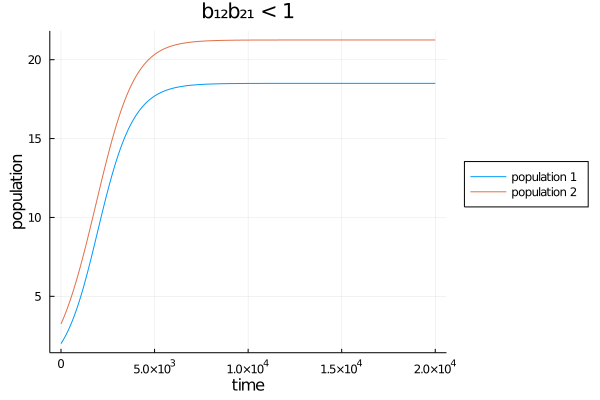

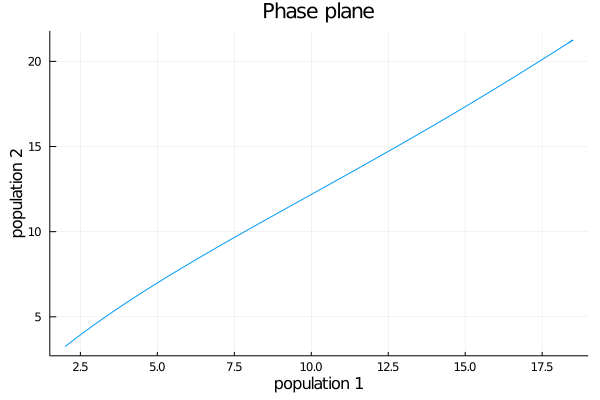

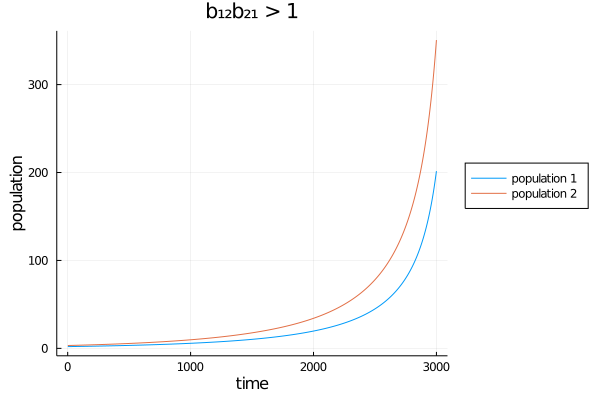

In [15]:
# first system of ODEs - b₁₂b₂₁ < 1
r1 = 1; r2 = 1; K1 = 10; K2 = 12; b12 = 0.4; b21 = 0.5;
arr = [(t, y₁, y₂) -> r1*y₁*(1 - y₁ / K1 + b12 * y₂ / K1)
       (t, y₁, y₂) -> r2*y₂*(1 - y₂ / K2 + b21 * y₁ / K2)]

# initial values
Y = [2., 3.25]

# solution
sol = runge_kutta(arr, 20, 0, Y)

# plotting
p = plot(sol[:, 1], xlabel="time", ylabel="population", label="population 1", title="b₁₂b₂₁ < 1", legend=:outerright)
plot!(sol[:, 2], label="population 2")
display(p)

# phase plane
p = plot(sol[:, 1], sol[:, 2], xlabel="population 1", ylabel="population 2", title="Phase plane", legend=nothing)
display(p)

# second system of ODEs - b₁₂b₂₁ > 1
b12 = 0.7; b21 = 2;  # only these two parameters are changed

# solution for the same initial value
sol = runge_kutta(arr, 3, 0, Y)

# plotting
p = plot(sol[:, 1], xlabel="time", ylabel="population", label="population 1", title="b₁₂b₂₁ > 1", legend=:outerright)
plot!(sol[:, 2], label="population 2")
display(p)

In the first case &mdash; $b_{12}b_{21} < 1$, we can see that after some time both populations stabilize at equilibrium point. Its both coordinates are bigger than environmental capacities $K_1$, $K_2$ due to the positive effect of mutualism.

For the case $b_{12}b_{21} > 1$, the mutualistic influence on both populations is very strong. This is why the growth of populations become unbounded. This shows us the drawbacks of this model and the need for looking for a more adequate one.

### Mutualism model with functional response

We can add a functional response of second type - saturating, hyperbolic type to our basic equations in a similar way as we did for prey-predation equations. Thus we get a system:

$$\begin{cases}
y_1' = y_1\left(r_1 + \frac{b_1 y_1}{K_1 + y_2} − d_1 y_1\right) \\ ̇
y_2' = y_2\left(r_2 + \frac{b_2 y_2}{K_2 + y_1} − d_2 y_2\right)
\end{cases}$$

In [ ]:
# Please do not run this cell in jupyter
r1 = 0.6; r2 = 0.45; b1 = 0.45; b2 = 0.3; K1 = 5; K2 = 7; d1 = 0.4; d2 = 0.35;
arr = [(t, y₁, y₂) -> y₁*(r1 + (b1 * y₁) / (K1 + y₂) - d1*y₁),
       (t, y₁, y₂) -> y₂*(r2 + (b2 * y₂) / (K2 + y₁) - d2*y₂)]

scene = phase_portrait(arr, 10, "Mutulaism with functional response", "population 1", "population 2")
save("mut_res.png", scene)

<img src="mut_res.png" width="700" height="450">

### Numerical solving

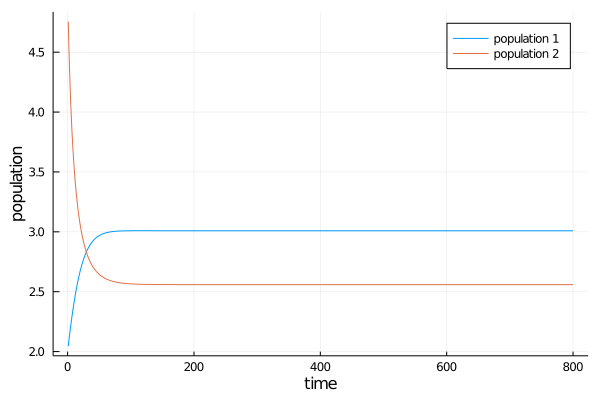

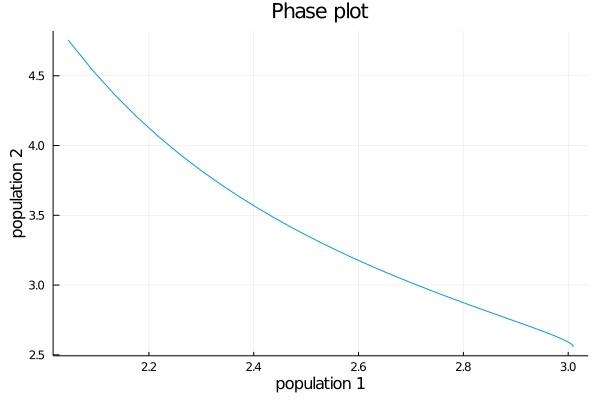

In [57]:
# system of ODEs
r1 = 1.2; r2 = 1.; b1 = b2 = 0.2; K1 = 8; K2 = 5; d₁ = 0.3; d₂ = 0.3
arr = [(t, y₁, y₂) -> y₁*(r1 + (b1 * y₁) / (K2 + y₂) - d₁*y₁),
       (t, y₁, y₂) -> y₂*(r2 + (b2 * y₂) / (K1 + y₁) - d₂*y₂)]

# initial condition
Y = [2., 5.]

# solution
sol = runge_kutta(arr, 20, 0, Y)

# plotting
p = plot(sol[:, 1], xlabel="time", ylabel="population", label="population 1")
plot!(sol[:, 2], label="population 2")
display(p)

# phase plot 
p = plot(sol[:, 1], sol[:, 2], legend=nothing, title="Phase plot", xlabel="population 1", ylabel="population 2")
display(p)

# Summary

Biology and maths and statistics blah

# References

[1] [PREDATOR-PREY DYNAMICS: LOTKA-VOLTERRA](http://www.tiem.utk.edu/~gross/bioed/bealsmodules/predator-prey.html)

[2] Murray "Mathematical Biology"

[3] Kot